# Playing around with KITTI odometry data

Let's take a crack at loading some KITTI data and seeing how it looks...

In [1]:
import numpy as np
import transforms3d

import matplotlib.pyplot as plt
plt.style.use('seaborn')

from utils import data  # custom loading package

In [2]:
df = data.get_kitti_data(drive='2011_09_30', sequence=27)
df.describe()

,lat,lon,alt,roll,pitch,yaw,vn,ve,vf,vl,...,wl,wu,pos_accuracy,vel_accuracy,navstat,numsats,posmode,velmode,orimode,timestamp
count,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,11556.000000,...,11556.000000,11556.000000,11556.000000,11556.000000,11556.0,11556.000000,11556.000000,11556.000000,11556.000000,1.155600e+04
mean,48.985894,8.394256,116.395527,0.022408,0.012067,0.238858,-0.035712,0.078931,5.990554,0.005675,...,0.000075,0.056196,0.063902,0.017448,4.0,8.161128,5.537037,5.530114,4.810142,1.317386e+09
std,0.000527,0.000953,0.163562,0.018286,0.006949,1.748334,4.815174,4.751953,3.144020,0.048789,...,0.022410,0.177369,0.035771,0.003665,0.0,1.111444,0.498648,0.499114,2.387938,3.336006e+01
min,48.985203,8.392773,116.066246,-0.009804,-0.012918,-3.140430,-10.191301,-9.166855,-0.099346,-0.183871,...,-0.091920,-0.569270,0.016401,0.011314,4.0,6.000000,5.000000,5.000000,0.000000,1.317386e+09
25%,48.985449,8.393594,116.312656,0.007057,0.008686,-0.508273,-3.048518,-4.244074,3.572412,-0.021713,...,-0.010046,-0.007454,0.026077,0.015556,4.0,7.000000,5.000000,5.000000,6.000000,1.317386e+09
50%,48.985721,8.393885,116.372520,0.019453,0.012772,-0.160590,-0.319364,0.003487,6.714392,0.007289,...,-0.000113,0.005621,0.058600,0.016971,4.0,8.000000,6.000000,6.000000,6.000000,1.317386e+09
75%,48.986410,8.395178,116.485821,0.040583,0.016361,1.716352,3.588199,3.602014,8.395403,0.030095,...,0.010193,0.067742,0.101912,0.019799,4.0,9.000000,6.000000,6.000000,6.000000,1.317387e+09
max,48.986737,8.395845,116.787468,0.075888,0.032923,3.141149,9.430235,7.466466,11.529455,0.189348,...,0.102644,0.582264,0.121659,0.028284,4.0,11.000000,6.000000,6.000000,6.000000,1.317387e+09


Text(0.5, 0, 'East [m]')

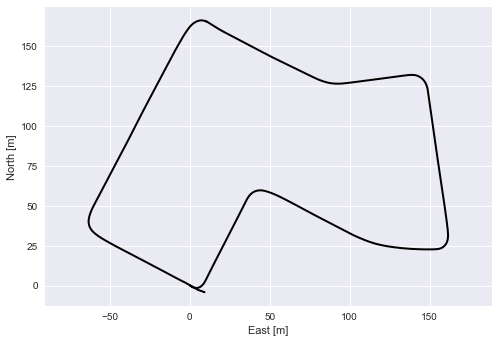

In [3]:
# Let's integrate ENU frame velocities and plot the BEV.
dts = np.diff(df['timestamp'])
p_NV_N = np.vstack(((dts * df['ve'][:-1]).cumsum(),
                    (dts * df['vn'][:-1]).cumsum(),
                    (dts * df['vu'][:-1]).cumsum())).T

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(p_NV_N[:, 0], p_NV_N[:, 1], 'k', lw=2)
ax.axis('equal')
ax.set_ylabel('North [m]')
ax.set_xlabel('East [m]')

Text(0.5, 0, 'elapsed time [s]')

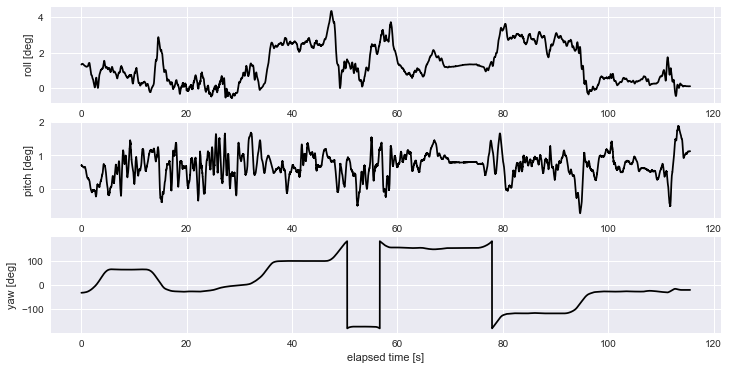

In [4]:
# We can check out vehicle orientation...
def _plot_orientation(ax, key):
    ax.plot(df['timestamp'] - df['timestamp'][0], np.rad2deg(df[key]), 'k')
    ax.set_ylabel(f'{key} [deg]')

fig = plt.figure(figsize=(12, 6))

axr = fig.add_subplot(311)
_plot_orientation(axr, 'roll')
axp = fig.add_subplot(312)
_plot_orientation(axp, 'pitch')
axy = fig.add_subplot(313)
_plot_orientation(axy, 'yaw')
axy.set_xlabel('elapsed time [s]')

Text(0.5, 0, 'elapsed time [s]')

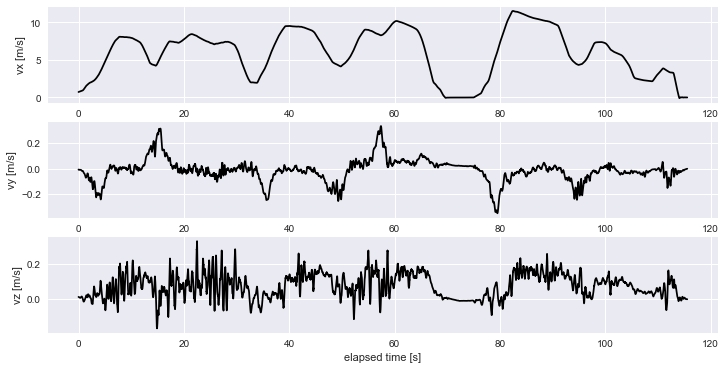

In [5]:
# Might be interesting to check out vehicle (IMU) frame velocities.

# Note: KITTI provides vf/vl/vu (some tangent frame) and ve/vn/vu (ENU frame) velocities. So we'll need
# to convert this to vehicle frame...
R_NV = np.array([transforms3d.euler.euler2mat(ri, pi, yi)
                 for ri, pi, yi in zip(df['roll'], df['pitch'], df['yaw'])])
v_NV_N = np.vstack((df['ve'], df['vn'], df['vu'])).T
v_NV_V = np.einsum('ij,ijk->ik', v_NV_N, R_NV)

def _plot_velocity(ax, v, key):
    ax.plot(df['timestamp'] - df['timestamp'][0], v, 'k')
    ax.set_ylabel(f'{key} [m/s]')
    
fig = plt.figure(figsize=(12, 6))

axx = fig.add_subplot(311)
_plot_velocity(axx, v_NV_V[:, 0], 'vx')
axy = fig.add_subplot(312)
_plot_velocity(axy, v_NV_V[:, 1], 'vy')
axz = fig.add_subplot(313)
_plot_velocity(axz, v_NV_V[:, 2], 'vz')
axz.set_xlabel('elapsed time [s]')

Notice in the above plots that both vehicle pitch and vz are greater than zero for nearly the entire loop yet the vehicle returns to the same position. This is likely due to some mounting offset.

KITTI reports translational offsets (that we should take into account if we later want to apply pseudo constraints while integrating accelerations) but no angular offsets.

<img src="http://www.cvlibs.net/datasets/kitti/images/setup_top_view.png" width="680" align='left'>

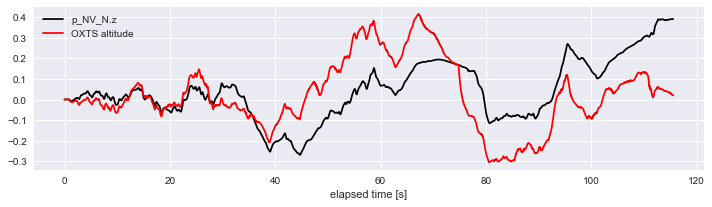

In [6]:
# Show that integrated 'vu' does not result in the same end altitude as the start.
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(111)
ax.plot(df['timestamp'][:-1] - df['timestamp'][0], p_NV_N[:, 2], 'k', label='p_NV_N.z')
ax.plot(df['timestamp'] - df['timestamp'][0], df['alt'] - df['alt'][0], 'r', label='OXTS altitude')
ax.set_xlabel('elapsed time [s]')
ax.legend()